## Import libraries and packages

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from pandas.tseries.offsets import Week
import seaborn as sns
import datetime as dt
import warnings
import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
import math
import pickle
from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
import pydot_ng as pydot
import yfinance as yf
from tensorflow.keras.utils import plot_model

## Set libraries settings

In [2]:
'''
to dislay the visualization in the "Out" part of Jupyter notebook
'''
%matplotlib inline
'''
values in dataframe will be with a precision of 4 decimal places 
'''
pd.set_option('display.float_format', lambda x: '%.4f' % x)

'''
seaborn visualization are set with preconfigured values(paper)
visualizations will have a dark background and the grid is visible
visualizations sized will be 12 by 6
'''
sns.set_context("paper", font_scale=1.5) 
sns.set_style('darkgrid')
sns.set_style(rc={"figsize":(13,10)})
FIG_SIZE = (13,10)

'''
remove all warnings from packages and libraries to have a clean notebook
'''
warnings.filterwarnings('ignore')

## Fetch data from Yahoo Finance

In [3]:
'''
Set the start, end date and ticker
fetch data with the specified parameters
'''
start_date = '2000-01-01'
end_date = '2022-03-03'
ticker = 'TSCO.L'
data = yf.download(ticker, start_date, end_date, interval="1d")


[*********************100%***********************]  1 of 1 completed


In [4]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-02-24,285.8500,287.3500,278.8500,279.6500,271.5579,24807025
2022-02-25,280.3000,288.4000,279.2000,286.5500,278.2582,22322138
2022-02-28,285.2500,289.9500,283.1000,289.7500,281.3657,28809655
2022-03-01,289.3500,293.6400,283.9500,283.9500,275.7335,22462044
2022-03-02,283.6500,286.8500,277.4800,282.6500,274.4711,34519806


## Select the two columns to be considered ["Open", "Close"]

In [5]:
df = data[["Open", "Close"]]

In [6]:
df

,Open,Close
Date,,
1999-12-31,238.4499,238.4499
2000-01-03,238.4499,238.4499
2000-01-04,239.3999,230.2165
2000-01-05,222.9332,234.0165
2000-01-06,234.0165,234.0165
...,...,...
2022-02-24,285.8500,279.6500
2022-02-25,280.3000,286.5500
2022-02-28,285.2500,289.7500


## Visualization of the data, open and close values

<AxesSubplot:xlabel='Date'>

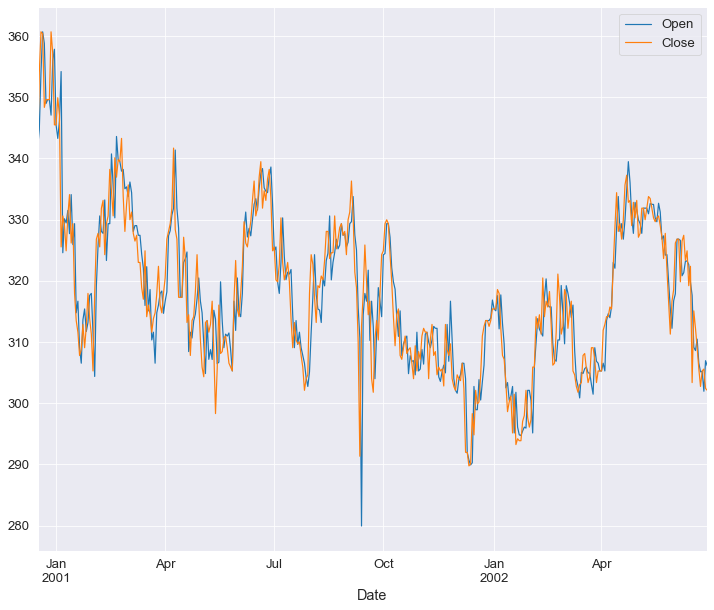

In [7]:
df.iloc[250:650,:].plot(figsize=(12,10))

## Resampling to yearly mean

In [8]:
df_year = df.resample("Y").mean()

## Visualization of the yearly mean data

<AxesSubplot:xlabel='Date'>

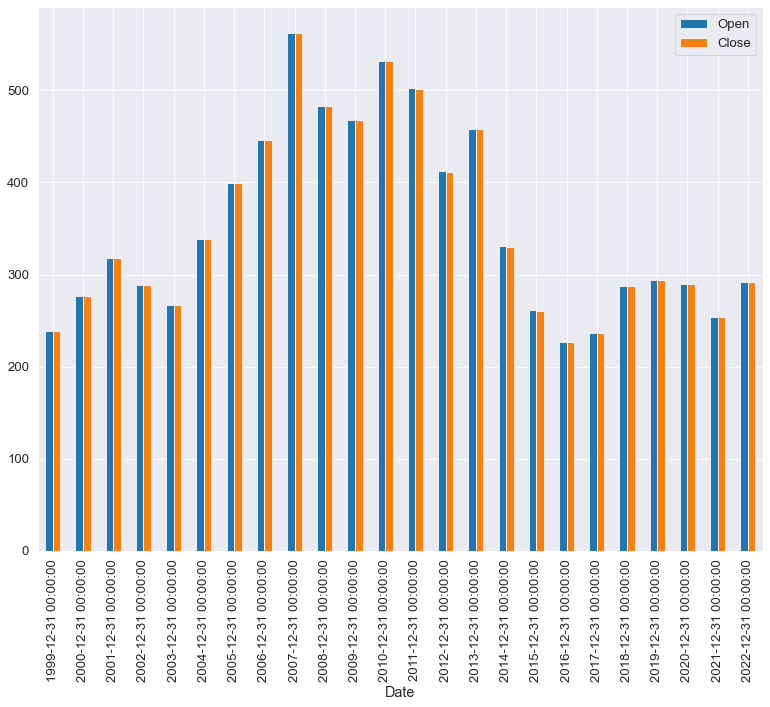

In [9]:
df_year.plot(kind='bar', figsize=FIG_SIZE)

<AxesSubplot:>

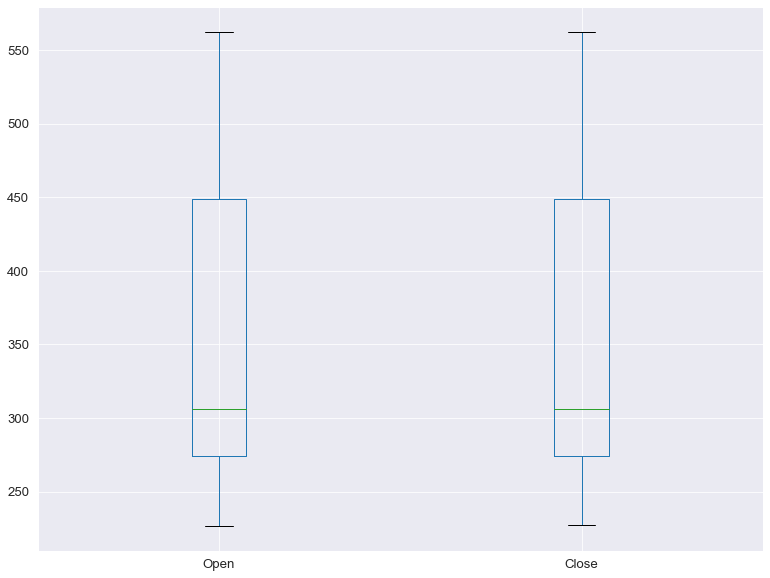

In [10]:
df_year.plot(kind='box', figsize=FIG_SIZE)

In [11]:
df["Close"]

Date
1999-12-31   238.4499
2000-01-03   238.4499
2000-01-04   230.2165
2000-01-05   234.0165
2000-01-06   234.0165
               ...   
2022-02-24   279.6500
2022-02-25   286.5500
2022-02-28   289.7500
2022-03-01   283.9500
2022-03-02   282.6500
Name: Close, Length: 5652, dtype: float64

## Feature extraction, end of week or not

In [12]:
df["End of week"] = df.index.dayofweek.map(lambda x: "end" if x == 4 else "not end")

In [13]:
df

,Open,Close,End of week
Date,,,
1999-12-31,238.4499,238.4499,end
2000-01-03,238.4499,238.4499,not end
2000-01-04,239.3999,230.2165,not end
2000-01-05,222.9332,234.0165,not end
2000-01-06,234.0165,234.0165,not end
...,...,...,...
2022-02-24,285.8500,279.6500,not end
2022-02-25,280.3000,286.5500,end
2022-02-28,285.2500,289.7500,not end


## Second experiment, using the Open and the close values to predict the close values

In [14]:
df["Close"]

Date
1999-12-31   238.4499
2000-01-03   238.4499
2000-01-04   230.2165
2000-01-05   234.0165
2000-01-06   234.0165
               ...   
2022-02-24   279.6500
2022-02-25   286.5500
2022-02-28   289.7500
2022-03-01   283.9500
2022-03-02   282.6500
Name: Close, Length: 5652, dtype: float64

In [15]:
df.iloc[:,1]

Date
1999-12-31   238.4499
2000-01-03   238.4499
2000-01-04   230.2165
2000-01-05   234.0165
2000-01-06   234.0165
               ...   
2022-02-24   279.6500
2022-02-25   286.5500
2022-02-28   289.7500
2022-03-01   283.9500
2022-03-02   282.6500
Name: Close, Length: 5652, dtype: float64

## Data Preprocessing

### Processing the features

In [16]:
'''
index the dataframe by picking the first two columns and turn to numpy array
initialize MinMax scaler 
get the transform values of the data
'''

dataset = df.iloc[:,[0,1]].values #numpy.ndarray
scaler_x = MinMaxScaler(feature_range=(0, 1))
dataset = scaler_x.fit_transform(dataset)

'''
manual train test split
using a ratio of 80%
'''

train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

### Processing the target variable

In [17]:
'''
index the dataframe to pick the column of the target variable and turn to numpy array
reshape the array so it can match the dimension of the scaler
'''
target_data = df.iloc[:,1].values
target_data = np.reshape(target_data, (-1, 1))
'''
normalize the target variable
initialize the scaler and tranform the data
'''
scaler_y = MinMaxScaler(feature_range=(0, 1))
target_data = scaler_y.fit_transform(target_data)
'''
manual train test split with a ratio of 80%
'''
train_y_size = int(len(target_data) * 0.80)
test_y_size = len(target_data) - train_y_size
train_y, test_y = target_data[0:train_y_size,:], target_data[train_y_size:len(dataset),:]


## Getting time steps

In [18]:
def create_dataset(features,target_data, look_back=1):
    '''
    function to create timesteps
    '''
    X, Y = [], []
    for i in range(len(features)-look_back-1):
        step = features[i:(i+look_back), :2] 
        X.append(step)
        Y.append(target_data[i + look_back, 0])
    return np.array(X), np.array(Y)

In [19]:
'''
calling the create_dataset function to create the timesteps
'''
look_back = 5
X_train, Y_train = create_dataset(train,train_y, look_back) 
X_test, Y_test = create_dataset(test,test_y, look_back)

In [20]:
X_train

array([[[0.140096  , 0.13903068],
        [0.140096  , 0.13903068],
        [0.14221225, 0.12060649],
        [0.10553043, 0.12910987],
        [0.13021998, 0.12910987]],

       [[0.140096  , 0.13903068],
        [0.14221225, 0.12060649],
        [0.10553043, 0.12910987],
        [0.13021998, 0.12910987],
        [0.13656875, 0.12202386]],

       [[0.14221225, 0.12060649],
        [0.10553043, 0.12910987],
        [0.13021998, 0.12910987],
        [0.13656875, 0.12202386],
        [0.12604408, 0.10572551]],

       ...,

       [[0.12175499, 0.12244904],
        [0.12485895, 0.11819731],
        [0.11935668, 0.12443301],
        [0.12514097, 0.13081057],
        [0.13431147, 0.12896824]],

       [[0.12485895, 0.11819731],
        [0.11935668, 0.12443301],
        [0.12514097, 0.13081057],
        [0.13431147, 0.12896824],
        [0.12965572, 0.13265312]],

       [[0.11935668, 0.12443301],
        [0.12514097, 0.13081057],
        [0.13431147, 0.12896824],
        [0.12965572, 0.13

In [23]:
X_train

array([[[0.140096  , 0.13903068],
        [0.140096  , 0.13903068],
        [0.14221225, 0.12060649],
        [0.10553043, 0.12910987],
        [0.13021998, 0.12910987]],

       [[0.140096  , 0.13903068],
        [0.14221225, 0.12060649],
        [0.10553043, 0.12910987],
        [0.13021998, 0.12910987],
        [0.13656875, 0.12202386]],

       [[0.14221225, 0.12060649],
        [0.10553043, 0.12910987],
        [0.13021998, 0.12910987],
        [0.13656875, 0.12202386],
        [0.12604408, 0.10572551]],

       ...,

       [[0.12175499, 0.12244904],
        [0.12485895, 0.11819731],
        [0.11935668, 0.12443301],
        [0.12514097, 0.13081057],
        [0.13431147, 0.12896824]],

       [[0.12485895, 0.11819731],
        [0.11935668, 0.12443301],
        [0.12514097, 0.13081057],
        [0.13431147, 0.12896824],
        [0.12965572, 0.13265312]],

       [[0.11935668, 0.12443301],
        [0.12514097, 0.13081057],
        [0.13431147, 0.12896824],
        [0.12965572, 0.13

In [24]:
Y_train

array([0.12202386, 0.10572551, 0.08871872, ..., 0.13265312, 0.13392864,
       0.13761328])

In [25]:
df.iloc[:8,:]

,Open,Close,End of week
Date,,,
1999-12-31,238.4499,238.4499,end
2000-01-03,238.4499,238.4499,not end
2000-01-04,239.3999,230.2165,not end
2000-01-05,222.9332,234.0165,not end
2000-01-06,234.0165,234.0165,not end
2000-01-07,236.8665,230.8499,end
2000-01-10,232.1419,223.5665,not end
2000-01-11,227.9999,215.9665,not end


In [26]:
Y_test.shape

(1125,)

## Model initialization

In [27]:
'''
using the Sequential API to build the model since we are using a linear model architecture
using a LSTM model
'''
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True)) 
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(30, return_sequences=True))
model.add(LSTM(20))
model.add(Dense(1))
'''
compile the model with mean squared error loss function with Adam optimizer
'''
model.compile(loss='mean_squared_error', optimizer='adam')

In [28]:
'''
model summary showing the parameter of the model
'''
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 100)            41200     
_________________________________________________________________
dropout (Dropout)            (None, 5, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 50)             30200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 30)             9720      
_________________________________________________________________
lstm_3 (LSTM)                (None, 20)                4080      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 85,221
Trainable params: 85,221
Non-trainable params: 0
____________________________________________________

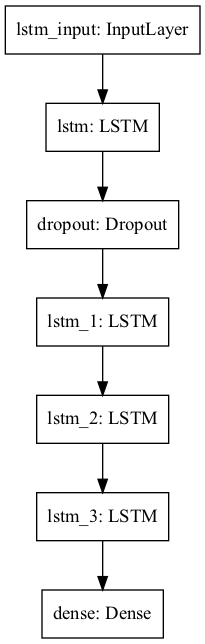

In [29]:
plot_model(model)

In [17]:
'''
model training parameters
'''
EPOCHS = 50
BATCH_SIZE = 5
VERBOSE = 1
SHUFFLE = False

## Model training

In [18]:
'''
train model with already specified paramteres above
'''
history = model.fit(X_train, Y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_data=(X_test, Y_test), 
                    verbose=VERBOSE, 
                    shuffle=SHUFFLE)

Epoch 1/50
903/903 [==============================] - 2s 2ms/step - loss: 0.0023 - val_loss: 0.0138
Epoch 2/50
903/903 [==============================] - 2s 2ms/step - loss: 0.0042 - val_loss: 0.0122
Epoch 3/50
903/903 [==============================] - 2s 2ms/step - loss: 0.0052 - val_loss: 0.0114
Epoch 4/50
903/903 [==============================] - 2s 2ms/step - loss: 0.0051 - val_loss: 0.0098
Epoch 5/50
903/903 [==============================] - 2s 2ms/step - loss: 0.0042 - val_loss: 0.0050
Epoch 6/50
903/903 [==============================] - 2s 2ms/step - loss: 0.0032 - val_loss: 0.0042
Epoch 7/50
903/903 [==============================] - 2s 2ms/step - loss: 0.0030 - val_loss: 0.0040
Epoch 8/50
903/903 [==============================] - 2s 2ms/step - loss: 0.0030 - val_loss: 0.0106
Epoch 9/50
903/903 [==============================] - 2s 2ms/step - loss: 0.0029 - val_loss: 0.0050
Epoch 10/50
903/903 [==============================] - 2s 2ms/step - loss: 0.0028 - val_loss: 0.0013

## Visualization of training and test loss during training

### Graph for first experiment

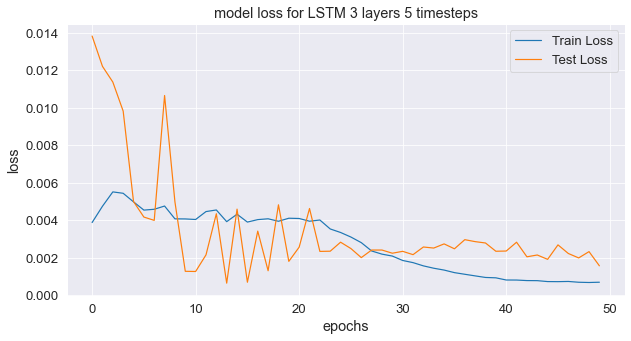

In [19]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss for LSTM 3 layers 5 timesteps')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

## Predictions

In [20]:
import time
start=time.time()
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler_y.inverse_transform(train_predict)
Y_train = scaler_y.inverse_transform(Y_train.reshape(-1,1))
test_predict = scaler_y.inverse_transform(test_predict)
Y_test = scaler_y.inverse_transform(Y_test.reshape(-1,1))
end=time.time()
prediction_time=end-start
print(prediction_time)

0.5704598426818848


## Evaluations

### Evaluation for this experiment

In [21]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train, train_predict)))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test, test_predict)))

Train Mean Absolute Error: 29.472458619110345
Train Root Mean Squared Error: 33.1964714913137
Test Mean Absolute Error: 16.416234049479165
Test Root Mean Squared Error: 17.70177721158524


## Visualization of real price vs predicted price 

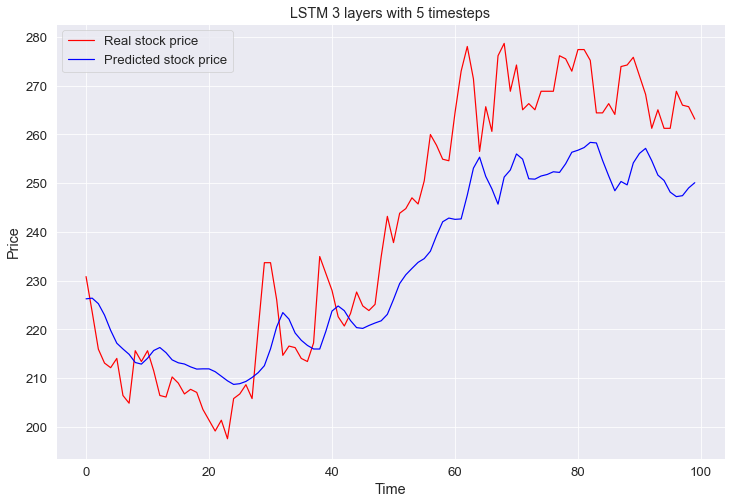

In [22]:
plt.figure(figsize=(12,8))
plt.plot(Y_train[:100], color = 'red', label = 'Real stock price')
plt.plot(train_predict[:100], color = 'blue', label = 'Predicted stock price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('LSTM 3 layers with 5 timesteps')
plt.legend()
plt.show()

## Test with entirely new data

### Fetch data

In [23]:
'''
set new start and end date
using the same ticker 
'''
start_date = '2022-03-04'
end_date = '2022-05-05'
'''
fetch new data with the specified parameters
'''

data = yf.download(ticker, start_date, end_date, interval="1d")


[*********************100%***********************]  1 of 1 completed


In [24]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-04-27,271.4000,274.5000,268.2000,273.6000,265.6830,18295919
2022-04-28,275.1000,275.2000,269.1000,272.3000,264.4206,13764025
2022-04-29,271.3000,275.1000,270.7570,272.0000,264.1293,19853422
2022-05-03,270.0000,277.4000,268.8000,276.7000,268.6933,32592907
2022-05-04,276.0000,277.9000,270.1000,271.7000,263.8380,14432045


### Select columns in contention

- I only want the Open and Close columns

In [25]:
'''
pick out the Open and Close columns in the dataset
'''
df = data[["Open", "Close"]]

### Normalizing the data

- I normalized the data before training in the beginning

In [26]:
'''
index out the data from the first and second columns and turn to numpy array
transfrom the array with the scaler_x for the features part 
'''
data = df.iloc[:,[0,1]].values
data = scaler_x.transform(data)

- Preview

In [27]:
data

array([[0.2362187 , 0.23514174],
       [0.23376828, 0.22160345],
       [0.21527894, 0.21589717],
       [0.20458625, 0.20079244],
       [0.20926429, 0.22037265],
       [0.21962279, 0.21880627],
       [0.22162764, 0.21578531],
       [0.21761793, 0.22518384],
       [0.22307566, 0.22865231],
       [0.23521623, 0.22675022],
       [0.2287561 , 0.22619078],
       [0.21873174, 0.22921174],
       [0.23020405, 0.22607892],
       [0.22975857, 0.22977118],
       [0.2319862 , 0.22328175],
       [0.22307566, 0.22093208],
       [0.2220732 , 0.22249853],
       [0.22574878, 0.23256835],
       [0.23710974, 0.23256835],
       [0.23510488, 0.23838648],
       [0.24111945, 0.22305796],
       [0.22552601, 0.22977118],
       [0.2281992 , 0.22283418],
       [0.22441219, 0.22014893],
       [0.2172838 , 0.21567345],
       [0.2188431 , 0.21567345],
       [0.21928865, 0.21254057],
       [0.21327401, 0.2212678 ],
       [0.21572442, 0.21097419],
       [0.18921557, 0.19889042],
       [0.

### process the target variable

In [28]:
'''
index out the target variable and turn to numpy array
reshape the array
'''
target_data = df.iloc[:,1].values
target_data = np.reshape(target_data, (-1, 1))
'''
transform the array with the scaler_y which is for the target variable
'''
target_data = scaler_y.transform(target_data)

In [29]:
target_data

array([[0.23514174],
       [0.22160345],
       [0.21589717],
       [0.20079244],
       [0.22037265],
       [0.21880627],
       [0.21578531],
       [0.22518384],
       [0.22865231],
       [0.22675022],
       [0.22619078],
       [0.22921174],
       [0.22607892],
       [0.22977118],
       [0.22328175],
       [0.22093208],
       [0.22249853],
       [0.23256835],
       [0.23256835],
       [0.23838648],
       [0.22305796],
       [0.22977118],
       [0.22283418],
       [0.22014893],
       [0.21567345],
       [0.21567345],
       [0.21254057],
       [0.2212678 ],
       [0.21097419],
       [0.19889042],
       [0.20135188],
       [0.21030283],
       [0.20179945],
       [0.19866663],
       [0.1997855 ],
       [0.20649871],
       [0.21007911],
       [0.21768741],
       [0.2147783 ],
       [0.21410701],
       [0.22462441],
       [0.21343572]])

In [30]:
'''
perform the timesteps function
'''
look_back = 5
X_test_new, Y_test_new = create_dataset(data,target_data, look_back) 

### Prediction

In [31]:
'''
perform a timed prediction
after the prediction, perform inverse transform to get the original prices
'''
start=time.time()

random_test = model.predict(X_test_new)
# invert predictions
test_new_predict = scaler_y.inverse_transform(random_test)
Y_test_new = scaler_y.inverse_transform(Y_test_new.reshape(-1,1))

end=time.time()

prediction_time=end-start

print(prediction_time)

0.05641818046569824


### Visualization of the real stock price and the predicted stock price

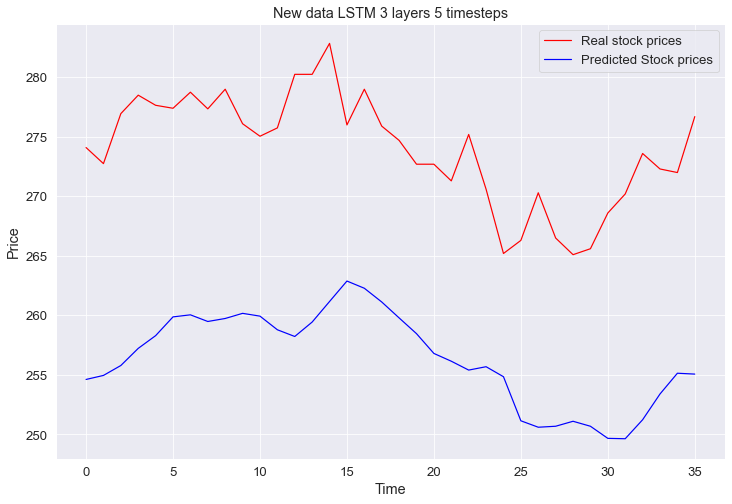

In [32]:
plt.figure(figsize=(12,8))
plt.plot(Y_test_new, color = 'red', label = 'Real stock prices')
plt.plot(test_new_predict, color = 'blue', label = 'Predicted Stock prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('New data LSTM 3 layers 5 timesteps')
plt.legend()
plt.show()

In [33]:
data.shape

(42, 2)

### Model evaluation with the new data

In [34]:
print('Test Mean Absolute Error:', mean_absolute_error(Y_test_new, test_new_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test_new, test_new_predict)))

Test Mean Absolute Error: 17.600453694661457
Test Root Mean Squared Error: 17.835011141412032
